<a href="https://colab.research.google.com/github/pragyapanwar23/image-integration/blob/main/flam_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from rembg import remove
from google.colab import files

In [ ]:
print("Upload person image")
uploaded = files.upload()
person_filename = next(iter(uploaded))

print("Upload background image")
uploaded = files.upload()
bg_filename = next(iter(uploaded))

Upload person image


Saving image1.jpg to image1.jpg
Upload background image


Saving bg2.jpg to bg2 (1).jpg


In [ ]:
!pip install mediapipe opencv-python pillow matplotlib --quiet

In [ ]:
import mediapipe as mp


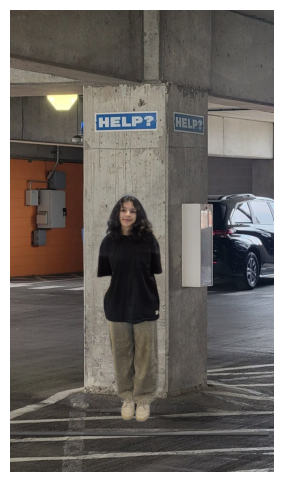

 Saved as final_result_grounded.jpg


In [ ]:
from PIL import Image, ImageDraw, ImageFilter
#remove background from person image
with open(person_filename, 'rb') as f:
    person_data = f.read()
person_nobg_data = remove(person_data)
with open("person_nobg.png", "wb") as f:
    f.write(person_nobg_data)
person_rgba = Image.open("person_nobg.png").convert("RGBA")

# Extract pose landmarks using MediaPipe
img_cv = cv2.imread("person_nobg.png", cv2.IMREAD_UNCHANGED)
img_rgb = cv2.cvtColor(img_cv[:, :, :3], cv2.COLOR_BGR2RGB)
pose = mp.solutions.pose.Pose(static_image_mode=True, model_complexity=2)
results = pose.process(img_rgb)

if not results.pose_landmarks:
    raise ValueError("Pose landmarks not detected.")

landmarks = results.pose_landmarks.landmark
orig_w, orig_h = person_rgba.size

def get_px(lm): return int(lm.x * orig_w), int(lm.y * orig_h)

# Get foot landmarks
lh = get_px(landmarks[mp.solutions.pose.PoseLandmark.LEFT_HEEL])
lf = get_px(landmarks[mp.solutions.pose.PoseLandmark.LEFT_FOOT_INDEX])
rh = get_px(landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HEEL])
rf = get_px(landmarks[mp.solutions.pose.PoseLandmark.RIGHT_FOOT_INDEX])

# Load and prepare background
bg = Image.open(bg_filename).convert("RGBA")
bg_width, bg_height = bg.size

# Resize person
scale_factor = 0.85
new_size = (int(orig_w * scale_factor), int(orig_h * scale_factor))
scale_x = new_size[0] / orig_w
scale_y = new_size[1] / orig_h
person_resized = person_rgba.resize(new_size, Image.Resampling.LANCZOS)

# Scale keypoints
lh = (int(lh[0] * scale_x), int(lh[1] * scale_y))
lf = (int(lf[0] * scale_x), int(lf[1] * scale_y))
rh = (int(rh[0] * scale_x), int(rh[1] * scale_y))
rf = (int(rf[0] * scale_x), int(rf[1] * scale_y))

# Slight shoe lift
def lift_shoe_front_v2(person_img, lift_px=4):
    width, height = person_img.size
    shoe_crop_height = int(height * 0.12)
    upper = person_img.crop((0, 0, width, height - shoe_crop_height))
    shoes = person_img.crop((0, height - shoe_crop_height, width, height))
    lifted_canvas = Image.new("RGBA", (width, shoe_crop_height), (0, 0, 0, 0))
    lifted_canvas.paste(shoes, (0, -lift_px), shoes)
    final = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    final.paste(upper, (0, 0))
    final.paste(lifted_canvas, (0, height - shoe_crop_height), lifted_canvas)
    return final

person_resized = lift_shoe_front_v2(person_resized)

# Person position
x = int(bg_width * -0.13)
y = int(bg_height - new_size[1] - 100)

# Update keypoints to background coords
lh = (lh[0] + x, lh[1] + y)
lf = (lf[0] + x, lf[1] + y)
rh = (rh[0] + x, rh[1] + y)
rf = (rf[0] + x, rf[1] + y)

# Contact shadow
def draw_shadow_from_keypoints(bg_size, lh, rh, lf, rf,
                                heel_opacity=110, toe_opacity=70, blur=2):
    shadow = Image.new("RGBA", bg_size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(shadow)
    radius = 10
    for pt in [lh, rh]:
        draw.ellipse([pt[0] - radius, pt[1], pt[0] + radius, pt[1] + radius // 2],
                     fill=(0, 0, 0, heel_opacity))
    for pt in [lf, rf]:
        draw.ellipse([pt[0] - radius + 2, pt[1], pt[0] + radius + 2, pt[1] + radius // 3],
                     fill=(0, 0, 0, toe_opacity))
    return shadow.filter(ImageFilter.GaussianBlur(blur))

contact_shadow = draw_shadow_from_keypoints(bg.size, lh, rh, lf, rf)

# Ambient light glow
def add_ambient_light_ring(shadow_img, foot_pts, radius=18, intensity=22):
    glow = Image.new("RGBA", shadow_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(glow)
    for pt in foot_pts:
        draw.ellipse([
            pt[0] - radius, pt[1] - radius // 2,
            pt[0] + radius, pt[1] + radius // 2
        ], fill=(200, 200, 200, intensity))
    return glow.filter(ImageFilter.GaussianBlur(10))

ambient_glow = add_ambient_light_ring(bg, [lh, rh, lf, rf])

# Occlusion under feet
def add_foot_occlusion_blur(feet_pts, radius=10, strength=90):
    shadow = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(shadow)
    for pt in feet_pts:
        draw.ellipse([pt[0] - radius, pt[1] - radius // 2,
                      pt[0] + radius, pt[1] + radius // 3],
                     fill=(0, 0, 0, strength))
    return shadow.filter(ImageFilter.GaussianBlur(6))

foot_occlusion = add_foot_occlusion_blur([lf, rf])

# Projected body shadow
def add_projected_shadow(person_img, position, scale_x=1.25, scale_y=0.25,
                         offset=(35, 12), opacity=60, blur=18):
    shadow = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    mask = person_img.split()[-1]
    stretched = mask.resize((int(person_img.width * scale_x),
                              int(person_img.height * scale_y)),
                             resample=Image.BICUBIC)
    shadow_rgba = Image.new("RGBA", stretched.size, (0, 0, 0, opacity))
    shadow_pos = (position[0] + offset[0],
                  position[1] + person_img.height - stretched.height + offset[1])
    shadow.paste(shadow_rgba, shadow_pos, stretched)
    return shadow.filter(ImageFilter.GaussianBlur(blur))

projected_shadow = add_projected_shadow(person_resized, (x, y))

# Tone down the person (optional)
def tone_down_person(person_img, brightness=0.98, contrast=0.95, sharpness=0.97):
    img = ImageEnhance.Brightness(person_img).enhance(brightness)
    img = ImageEnhance.Contrast(img).enhance(contrast)
    img = ImageEnhance.Sharpness(img).enhance(sharpness)
    return img

# Feather the bottom of the legs
def fade_leg_bottom(person_img, fade_height=15):
    width, height = person_img.size
    alpha = person_img.split()[-1]
    gradient = Image.new('L', (1, fade_height), color=0)
    for y in range(fade_height):
        gradient.putpixel((0, y), int(255 * (y / fade_height)))
    alpha_gradient = gradient.resize((width, fade_height))
    alpha.paste(alpha_gradient, (0, height - fade_height))
    return Image.merge("RGBA", (*person_img.split()[:3], alpha))

# Final composite
composite = Image.alpha_composite(bg, projected_shadow)
composite = Image.alpha_composite(composite, contact_shadow)
composite = Image.alpha_composite(composite, ambient_glow)
composite = Image.alpha_composite(composite, foot_occlusion)

person_resized = tone_down_person(person_resized)
person_resized = fade_leg_bottom(person_resized)
composite.paste(person_resized, (x, y), person_resized)

# Display and save
plt.figure(figsize=(6, 6))
plt.imshow(composite)
plt.axis("off")
plt.show()

composite.convert("RGB").save("final_result_grounded.jpg")
print(" Saved as final_result_grounded.jpg")

In [ ]:
!pip install streamlit rembg opencv-python mediapipe pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.57.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.4 which 

In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image

st.title("Final Composited Image Viewer")
st.markdown("**Note:** This deployment can only display the final image formed at the end of the model due to time constraints.")
# Load and show image
image_path = "final_result_grounded.jpg"  # Update with the path to your generated image
img = Image.open(image_path)
st.image(img, caption="Seamlessly Integrated Image", width=350)



Overwriting app.py


In [ ]:
import os
import time

# Kill any previous Streamlit process if running
os.system("pkill streamlit")

# Start Streamlit in background
os.system("streamlit run app.py &")
time.sleep(5)  # Give Streamlit some time to spin up


In [ ]:
from pyngrok import ngrok

# Replace with your actual token only — no `ngrok config add-authtoken` command text
ngrok.set_auth_token("2yRUkRCbgR6P4lXhyJQEcSgWIsP_4rEFP6EVgWAbQ51DSwU3p")

public_url = ngrok.connect(addr="8501", proto="http")
print("🌍 Public URL:", public_url)


🌍 Public URL: NgrokTunnel: "https://10aa-34-106-33-170.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!curl http://localhost:8501